# Simulation Example

In this jupyter notebook we demonstrate how our prototyping infrastructure can be used for designing QPUs that solve the CSP problem for arbitrary crystal structures.

We begin by making the necessary package imports for this purpose. Notice that the `Prototype` package was developed by the team for the purposes of this Hackathon.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Prototype.plotting_helper import *
from Prototype.crystals.crystal_structure import CrystalStructure
from Prototype.simulation.sequence_builder import SequenceBuilder
from Prototype.simulation.simulation_runner import SimulationRunner

Now we import the crystal of interest from the `native_crystal_database` directory. For more information on how CSP problems are encoded in these files, refer to the `Readme.md` file on the same directory, or this link: [here](https://github.com/azhutov/cspraa/tree/main/native_crystal_database).

In [2]:
crystal = CrystalStructure.from_file("../../native_crystal_database/edge.dat")


Now we use our `SequenceBuilder` class to generate a QPU for solving the CSP problem on the defined crystal.
To see the configs, go to this file: [default.yml](https://github.com/azhutov/cspraa/blob/main/Prototype/simulation/configs/default.yml).

In [3]:
seq_builder = SequenceBuilder(crystal, configs="default")
seq, back_converter = seq_builder.create_sequence()

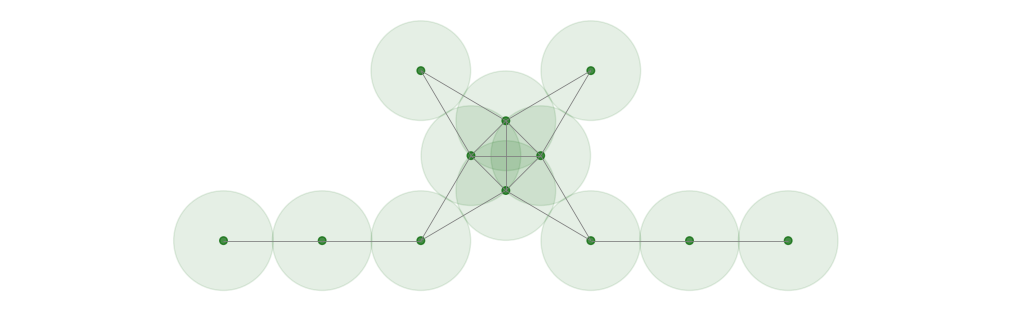

In [4]:
seq.register.draw(
    with_labels = False,
    blockade_radius = seq._device.rydberg_blockade_radius(seq_builder.omega_max),
    draw_half_radius = True,
    show = False
)
plt.gca().legend().remove()
plt.gca().axis("off")
plt.show()

Now we instantiate an object of the `SimulationRunner` class, the class we designed for simulating the quantum algorithm.

In [5]:
runner = SimulationRunner()

Depending on the size of the problem, we may decide to run the problem on a local machine or submit to the Pasqal Cloud for simulation/running on a real Quantum device. This behavior can be controlled through the `run_locally` variable defined below.

In [6]:
# Change this variable to determine whether a local processor is used for the simulation or the jobs are sent to the Pasqal Cloud.
run_locally = True

Running this cell can take some time! From our experience sometimes up to 3 hours for larger problems. For a single edge crystal it should take less than 2 minutes when simulated classically.
Note that changing the problem to different crystals may require the optimization of certain parameters such as $\Omega_{max}$ and $\Delta_{max}$ to get proper results.

In [7]:
if not run_locally:
    runner.send_batch(seq, 10000)
    batch = runner.wait_and_get_last_sent_batch(wait_time = 60*15) # Waiting a maximum of 15 minutes
    if batch.status != "DONE":
        if batch.status in ["RUNNING", "PENDING"]:
            raise Exception("Job did not finish in the allotted time.")
        elif batch.status == "ERROR":
            raise Exception("Job failed. See the error message/logs on the cloud for more information.")
    count_dict = batch.result
else:
    count_dict = runner.simulate_locally(seq, runs=10000)

10.0%. Run time:   6.04s. Est. time left: 00:00:00:54
20.0%. Run time:  10.93s. Est. time left: 00:00:00:43
30.0%. Run time:  16.93s. Est. time left: 00:00:00:39
40.0%. Run time:  22.81s. Est. time left: 00:00:00:34
50.0%. Run time:  29.40s. Est. time left: 00:00:00:29
60.0%. Run time:  35.62s. Est. time left: 00:00:00:23
70.0%. Run time:  41.75s. Est. time left: 00:00:00:17
80.0%. Run time:  47.86s. Est. time left: 00:00:00:11
90.0%. Run time:  58.74s. Est. time left: 00:00:00:06
Total run time:  69.46s


Now we plot the results of our quantum simulation, and convert the results back in to the desired crystal structure.

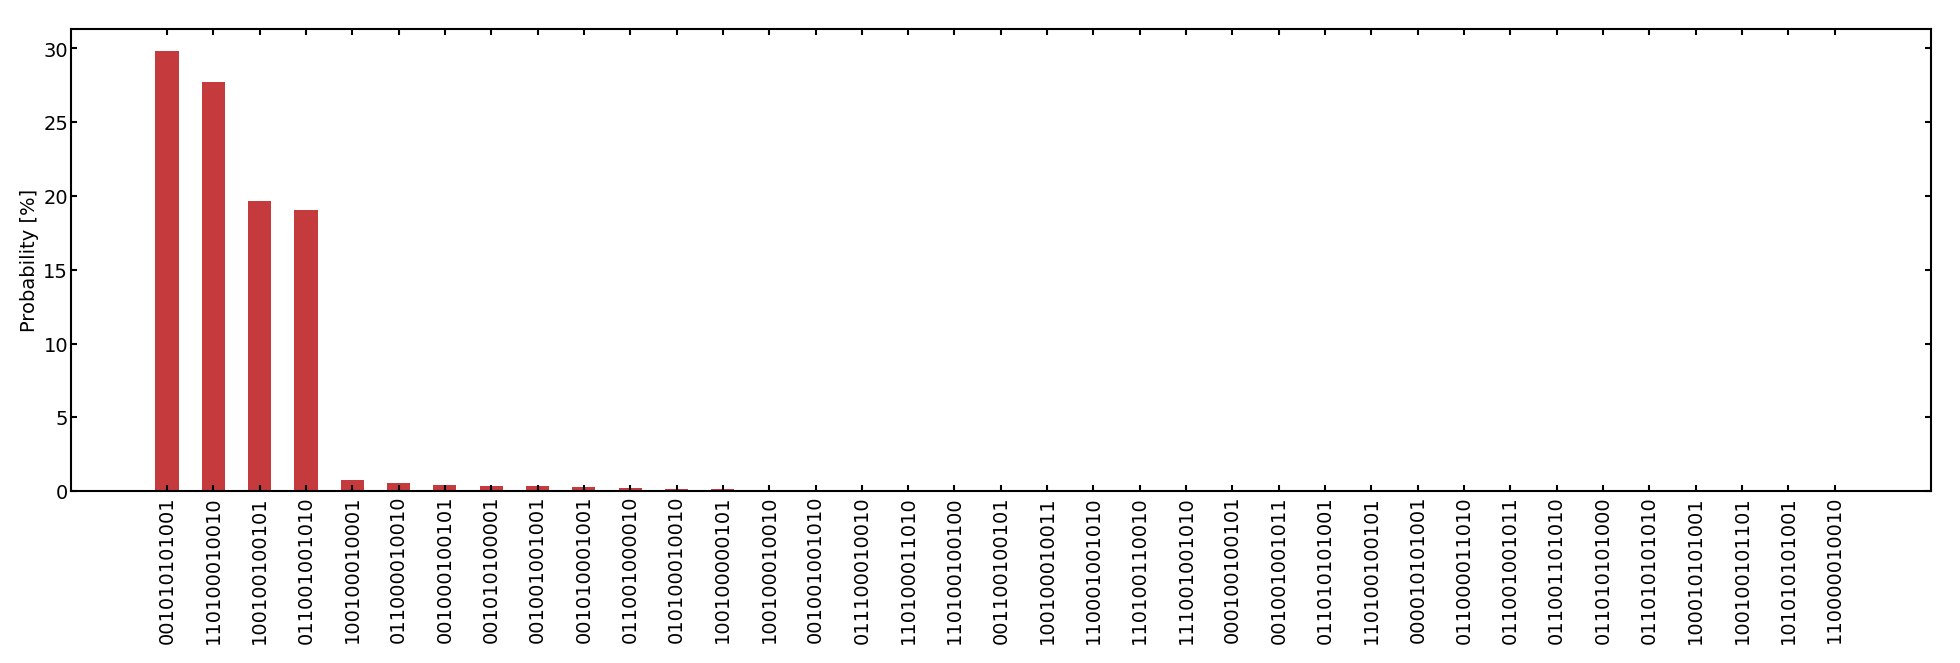

In [8]:
fig, ax = getStylishFigureAxes(1, 1, figsize=(12,3))

ax.bar(count_dict.keys(), 100 * np.array(list(count_dict.values()))/sum(list(count_dict.values())), width=0.5)
plt.xticks(rotation=90)
ax.set_ylabel("Probability [%]")

plt.show()

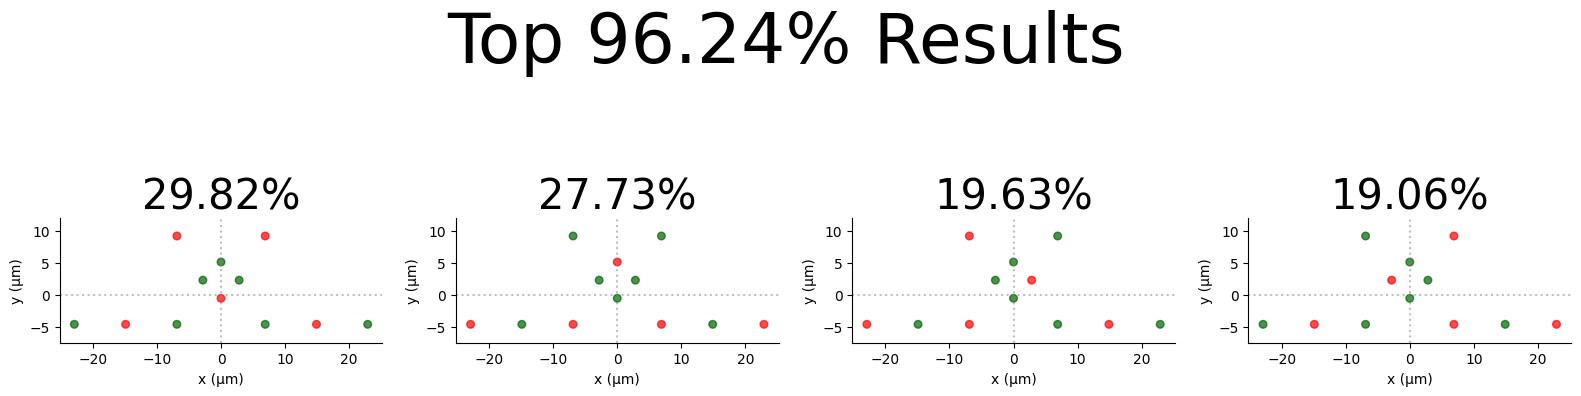

In [9]:
nrows, ncols = 1, 4
fig, ax = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), dpi=100)
ax = ax.ravel()

total_count = sum(list(count_dict.values()))
count_covered = 0
for i in range(min(len(ax), len(count_dict))):
    m = list(count_dict.keys())[i]
    seq.register.draw(
        qubit_colors={f"q{k}": "red" for k in range(len(m)) if m[k] == '1'},
        show = False,
        custom_ax=ax[i],
        with_labels = False
    )
    percentage = count_dict[m]/total_count * 100
    count_covered += count_dict[m]
    ax[i].set_title(f"{str(round(percentage, 2))}%", fontsize=30)
    ax[i].get_legend().set_visible(False)
for i in range(len(count_dict), len(ax)):
    ax[i].set_visible(False)

plt.suptitle(f"Top {str(round(count_covered/total_count*100, 2))}% Results\n", fontsize=50)
plt.tight_layout()
plt.show()

Now we map this back into the shape of the most stable crystal structure.

c:\Users\sorou\OneDrive\Desktop\Soroush\university\Waterloo\hackathon\reGenerativeQuantumChallenge\.venv\Lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


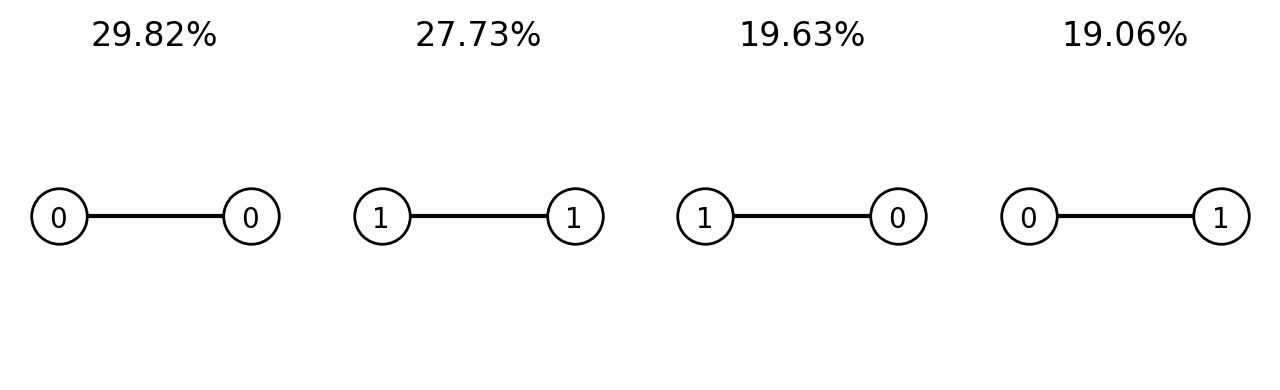

In [79]:
if crystal.dimension != 2:
    print("we can only plot 2D crystals here.")

fig, axes = getStylishFigureAxes(1, 4)

for index, ax in enumerate(axes):
    result = back_converter.convert_to_atoms(list(count_dict.keys())[index])
    atoms = []
    for i in range(crystal.vertices_count):
        l: str = result["bits"][i*crystal.species_count:(i+1)*crystal.species_count]
        atoms += [np.where(l == 1)[0][0]]
    for i in range(crystal.vertices_count):
        PlotPlotter(
            fig,
            ax,
            crystal.positions[i][0],
            crystal.positions[i][1],
            style = {"marker": "o", "markersize": 20, "color": "white", "markeredgecolor": "black"}
        ).draw()
        ax.text(
            crystal.positions[i][0]-0.05,
            crystal.positions[i][1]-0.005,
            atoms[i]
        )
    for i, j in crystal.interactions.keys():
        PlotPlotter(
            fig,
            ax,
            [crystal.positions[i][0], crystal.positions[j][0]],
            [crystal.positions[i][1], crystal.positions[j][1]],
            style = {"markeredgecolor": "black", "linestyle": "-", "color": "black", "zorder": -1}
        ).draw()

    ax.set_aspect("auto")
    ax.autoscale()
    ax.set_xmargin(0.2)
    ax.set_ymargin(0.2)
    ax.axis("off")
    ax.set_title(f"{str(round(list(count_dict.values())[index] / sum(list(count_dict.values())) * 100, 2))}%")
plt.show()